In [1]:
import os
import datetime
import math
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import ewtpy
import joblib

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

In [2]:
# DATA
df1 = pd.read_csv('data/data_day.csv')
df2 = pd.read_csv('data/data_2018-08-05_2021-04-30.csv')
df3 = pd.read_csv('data/data_2018-05-05_2018-08-04.csv')
df4 = pd.read_csv('data/data_2015-08-09_2018-05-04.csv')
df5 = pd.read_csv('data/data_2013-02-12_2015-08-08.csv')
df6 = pd.read_csv('data/data_2010-05-19_to_2013-02-11.csv')
df7 = pd.read_csv('data/data_2007-08-23_to_2010-05-18.csv')
df8 = pd.read_csv('data/data_2004-11-26_to_2007-08-22.csv')
# df_test = pd.read_csv('Hanoi 2024-01-22 to 2024-05-01.csv')
df = pd.concat([df6, df5, df4, df3, df2, df1])
df.index = range(0,len(df))
df.tail()
date_time = pd.concat([pd.to_datetime(df['datetime'][0:4000]),pd.to_datetime(df['datetime'][4000:])])
data_use = df[['temp','tempmax', 'tempmin','humidity', 'precip', 'windspeed', 'solarradiation', 'solarenergy']]

print(data_use)

      temp  tempmax  tempmin  humidity  precip  windspeed  solarradiation  \
0     30.8     36.5     26.0      78.1   0.000       20.5           301.4   
1     31.3     36.4     27.0      76.0   0.300       24.1           281.5   
2     30.7     39.0     26.0      76.1   2.300       40.7           237.1   
3     31.5     39.6     26.0      71.2   0.800       15.1           296.8   
4     27.6     30.8     25.8      80.1  33.000       22.7           240.8   
...    ...      ...      ...       ...     ...        ...             ...   
4991  20.5     22.0     19.5      93.8   8.794       17.5           148.7   
4992  22.4     26.5     20.0      84.5   0.683       19.4           140.8   
4993  22.6     26.6     20.0      85.5   0.072       20.3           131.9   
4994  23.0     26.0     19.0      82.4   3.300       20.5            63.7   
4995  16.0     18.0     14.0      91.4   3.400       22.3            15.8   

      solarenergy  
0            26.1  
1            24.3  
2            20

In [3]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s[1] - timestamp_s[0]

86400.0

C:\Users\tridu\AppData\Local\Temp\ipykernel_10212\1206436225.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
C:\Users\tridu\AppData\Local\Temp\ipykernel_10212\1206436225.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


Index(['temp', 'tempmax', 'tempmin', 'humidity', 'precip', 'windspeed',
       'solarradiation', 'solarenergy', 'Year sin', 'Year cos'],
      dtype='object')

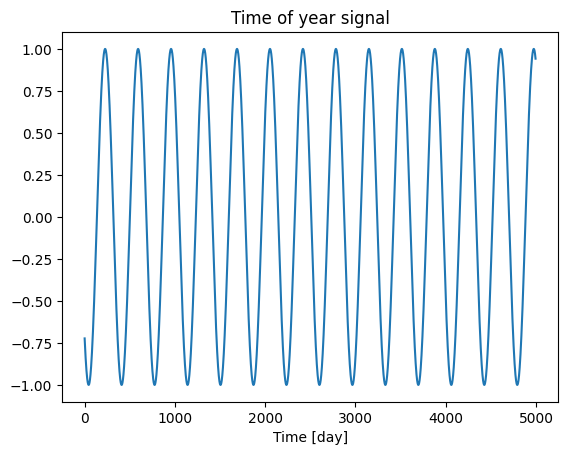

In [4]:
# PERIOD TIME

day = 24*60*60
year = (365.2425)*day
# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# plt.plot(np.array(df['Year sin'])[:366])
plt.plot(np.array(data_use['Year cos'])[:])
plt.xlabel('Time [day]')
plt.title('Time of year signal')
data_use.columns

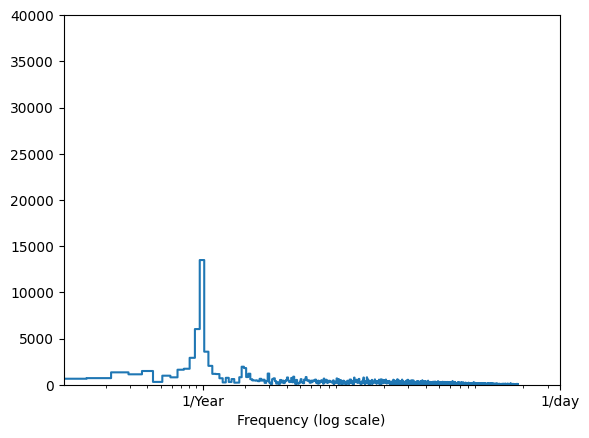

In [5]:
fft = tf.signal.rfft(data_use['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_day = len(data_use['humidity'])
days_per_year = 365.2524
years_per_dataset = n_samples_day/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [6]:
def decompose_to_ewt(data, N):
    temp_data,  mfb ,boundaries = ewtpy.EWT1D(data, N)
    return temp_data, mfb, boundaries
# def split_mode(ewt, N):
#     modes = [[] for _ in range(N)]
#     for i in range(N):
#         modes[i] = [m for m in ewt[:,i]]
#     return modes
def add_ewt_to_data(data, ewt_transpose, N):
    for i in range(N):
        data['ewt'+str(i)] = ewt_transpose[i]
    return data

In [7]:
number = 32
temp_ewt, mfb, boundaries = decompose_to_ewt(data_use['temp'], N = number)
temp_ewt_transpose = np.transpose(temp_ewt)
# modes = split_mode(temp_ewt, N = number)
# for i in range(number):
#     plt.plot(modes[i])
#     plt.show()
data_use = add_ewt_to_data(data_use, temp_ewt_transpose, N = number)

C:\Users\tridu\AppData\Local\Temp\ipykernel_10212\1208021920.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ewt'+str(i)] = ewt_transpose[i]
C:\Users\tridu\AppData\Local\Temp\ipykernel_10212\1208021920.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ewt'+str(i)] = ewt_transpose[i]
C:\Users\tridu\AppData\Local\Temp\ipykernel_10212\1208021920.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [8]:
number_train = 0.8
in_steps = 365
out_steps = 7
labels = ['temp']
num_features = len(labels)
print(num_features)

1


In [9]:
def create_data(in_steps, out_steps, data, labels):
    X = []
    y = []
    for i in range(len(data)-in_steps-out_steps + 1):
        X.append(data[i:i+in_steps])
        y.append(data[i+in_steps:i+in_steps+out_steps][labels])
    return np.array(X), np.array(y)
def normalize(data, train_mean, train_std):
    data_norm = (data - train_mean)/train_std
    return data_norm
def unnormalize(data, train_mean, train_std):
    data_unnorm = (data * train_std) + train_mean
    return data_unnorm


In [10]:
def data_split(data_use, number):
    number_train = int(data_use.shape[0] * number)
    train, test = data_use[0:number_train], data_use[number_train:]
    return train, test

In [11]:
def create_data_train(data_use, number_train: float, in_steps: int, out_steps: int, labels):
    train, test = data_split(data_use, number_train)
    X_train, y_train = create_data(in_steps, out_steps, train, labels = labels)
    print(X_train.shape)
    print(y_train.shape)
    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], num_features)

    X_test, y_test = create_data(in_steps, out_steps, test, labels = labels)
    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], num_features)
    
    return X_train, y_train, X_test, y_test

In [12]:
X_train, y_train, X_test, y_test = create_data_train(
    number_train=number_train, in_steps=in_steps, out_steps=out_steps, data_use=data_use, labels=labels)


(3625, 365, 42)
(3625, 7, 1)


In [13]:
X_train_norm = normalize(X_train, X_train.mean(), X_train.std())
y_train_norm = normalize(y_train, y_train.mean(), y_train.std())
X_test_norm = normalize(X_test, X_train.mean(), X_train.std())
y_test_norm = normalize(y_test, y_train.mean(), y_train.std())

In [ ]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(out_steps*num_features),
    tf.keras.layers.Reshape([out_steps, num_features])
])

In [ ]:
# Định nghĩa lớp SliceLayer
class SliceLayer(tf.keras.layers.Layer):
    def __init__(self, start, stop, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.start = start
        self.stop = stop

    def call(self, inputs):
        return inputs[:, self.start:self.stop, :]

    def get_config(self):
        config = super(SliceLayer, self).get_config()
        config.update({'start': self.start, 'stop': self.stop})
        return config


# Sử dụng lớp SliceLayer trong mô hình
CONV_WIDTH = 5
model = tf.keras.Sequential([
    # Sử dụng SliceLayer để cắt tensor
    SliceLayer(start=-CONV_WIDTH, stop=None),
    # Shape => [batch, CONV_WIDTH, features]
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Dense(out_steps*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Reshape([out_steps, num_features])
    # Shape => [batch, out_steps, features]
])

# Đảm bảo thay thế `# số bước đầu ra mong muốn` và `# số đặc trưng` bằng các giá trị thực tế

In [ ]:
def compile(model, X_train_norm, y_train_norm, epochs, batch_size, validation_split, validation_batch_size):
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Lion(learning_rate=0.001),
    )
    history = model.fit(X_train_norm, y_train_norm, epochs=epochs, validation_split=validation_split,
                        batch_size=batch_size, validation_batch_size=validation_batch_size)
    return history

In [ ]:
history = compile(model_lstm, X_train_norm, y_train_norm, epochs=10, batch_size=32, validation_split=0.2, validation_batch_size=32)

In [14]:
def save_model(model, name: str, path: str, lag: int, out_steps: int, feature_train: str, optional="") -> str:
    model.save(
        f"{path}/{name}_{lag}_{out_steps}_{feature_train}_{optional}.keras")
    return f"{name}_{lag}_{out_steps}_{feature_train}_{optional}.keras"

def load_model(name: str, path: str, have_custom_objects: bool = False, custom_layer: object = None, custom_layer_name: str = None):
    if have_custom_objects:
        return tf.keras.models.load_model(f"{path}/{name}", custom_objects={custom_layer_name: custom_layer})
    return tf.keras.models.load_model(f"{path}/{name}")

In [ ]:
lstm_model_name = save_model(model_lstm, "lstm", "model_final", in_steps, out_steps, "temp", "new_FINAL_32_ewt")

In [113]:
model_name = "lstm_365_7_temp_new_FINAL_32_ewt"
lstm_recall = load_model(model_name + '.keras', "model_final", have_custom_objects=False)

In [114]:
lstm_recall.evaluate(X_test_norm, y_test_norm)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0899


0.0955495834350586

In [ ]:
# number_train = int(data_use.shape[0] * 0.8)
# train, test = data_use[0:number_train], data_use[number_train:]

In [ ]:
# in_steps = 365
# out_steps = 7
# features_train = ['temp']
# num_features = len(features_train) 

In [ ]:
# X_train, y_train = create_data(in_steps, out_steps, train, features_train)
# y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], num_features)

# X_test, y_test = create_data(in_steps, out_steps, test, features_train)
# y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], num_features)

# X_train_norm = normalize(X_train, X_train.mean(), X_train.std())
# y_train_norm = normalize(y_train, y_train.mean(), y_train.std())

# X_test_norm = normalize(X_test, X_train.mean(), X_train.std())
# y_test_norm = normalize(y_test, y_train.mean(), y_train.std())

# print(X_train_norm.shape, y_train_norm.shape, X_test_norm.shape, y_test_norm.shape)

In [ ]:
# Định nghĩa lớp SliceLayer
class SliceLayer(tf.keras.layers.Layer):
    def __init__(self, start, stop, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.start = start
        self.stop = stop

    def call(self, inputs):
        return inputs[:, self.start:self.stop, :]

    def get_config(self):
        config = super(SliceLayer, self).get_config()
        config.update({'start': self.start, 'stop': self.stop})
        return config

In [21]:
def create_mae_list(y_true, y_pred, feature_train : int):
    mae_list = []
    for i in range(y_true.shape[1]):
        mae = mean_absolute_error(y_true[:,i,feature_train], y_pred[:,i,feature_train])
        mae_list.append(mae)
    return mae_list
def create_rmse_list(y_true, y_pred, feature_train : int):
    rmse_list = []
    for i in range(y_true.shape[1]):
        rmse = math.sqrt(mean_squared_error(y_true[:,i,feature_train], y_pred[:,i,feature_train]))
        rmse_list.append(rmse)
    return rmse_list
def create_corr_list(y_true, y_pred, feature_train : int):
    corr_list = []
    for i in range(y_true.shape[1]):
        corr = np.corrcoef(y_true[:,i,feature_train], y_pred[:,i,feature_train])
        corr_list.append(corr[0,1])
    return corr_list
def plot_sample(start_day, last_day, sample, y_test, y_pred):
    for i in range(start_day, last_day, sample):
        plt.title(f"Day {i+1}")
        plt.plot(y_test[i,:,0], label='True')
        plt.plot(y_pred[i,:,0], label='Predict')
        plt.show()
        plt.legend()
def plot_day(day, y_test, y_pred):
    plt.title(f"Day {day+1}")
    plt.plot(y_test[day,:,0], label='True')
    plt.plot(y_pred[day,:,0], label='Predict')
    plt.legend()
    plt.show()

In [23]:
predictions = lstm_recall.predict(X_test_norm)
predictions_unnorm = unnormalize(predictions, y_train.mean(), y_train.std())

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [27]:

mae_list = create_mae_list(y_test, predictions_unnorm, 0)
rmse_list = create_rmse_list(y_test, predictions_unnorm, 0)
corr_list = create_corr_list(y_test, predictions_unnorm, 0)

print(mae_list)
print(rmse_list)
print(corr_list)



[0.9535516556950556, 1.0976397406694811, 1.1398679451267746, 1.2110350843832869, 1.3062096330433468, 1.4234344421774858, 1.4739835754297497]
[1.2183321415827177, 1.404224989279012, 1.4581210619032485, 1.552951834628089, 1.7039080318061885, 1.8564244715481784, 1.9450866503829434]
[0.967896134274376, 0.9558571390753159, 0.951664897747084, 0.9456359690540389, 0.9352659598323662, 0.9281339981867683, 0.9216798284099162]


In [248]:
# Initialize the data frame

# Tạo bộ dữ liệu theo mong muốn của mình
list_metric = ['MAE', 'RMSE', 'Corr']

def initial_dataframe(_list_model):
    columns = ['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7']
    list_model = _list_model
    multi_index = pd.MultiIndex.from_product([list_metric, list_model], names = ['Metric', 'Model'])
    data = pd.DataFrame(columns=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7'], index = multi_index)
    return data,list_model

In [249]:
Thêm mô hình vào bộ dữ liệu
def add_new_model_metric(data, model_name, mae_list, rmse_list, corr_list,list_model):
    if model_name not in list_model:
        list_model.append(model_name)
        multi_index = pd.MultiIndex.from_product([list_metric, list_model], names = ['Metric', 'Model'])
        data = data.reindex(columns=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7'], index = multi_index)
        data.loc[('MAE', model_name)] = mae_list
        data.loc[('RMSE', model_name)] = rmse_list
        data.loc[('Corr', model_name)] = corr_list
    else:
        print(model_name + " is already in the list")
    return data

In [263]:
data_01, list_model_x01 = initial_dataframe([])

In [264]:
data_01 = add_new_model_metric(data_01, model_name, mae_list, rmse_list, corr_list, list_model_x01)

In [265]:
print(data_01)

                                            Day 1     Day 2     Day 3  \
Metric Model                                                            
MAE    lstm_365_7_temp_new_FINAL_32_ewt  0.953552   1.09764  1.139868   
RMSE   lstm_365_7_temp_new_FINAL_32_ewt  1.218332  1.404225  1.458121   
Corr   lstm_365_7_temp_new_FINAL_32_ewt  0.967896  0.955857  0.951665   

                                            Day 4     Day 5     Day 6  \
Metric Model                                                            
MAE    lstm_365_7_temp_new_FINAL_32_ewt  1.211035   1.30621  1.423434   
RMSE   lstm_365_7_temp_new_FINAL_32_ewt  1.552952  1.703908  1.856424   
Corr   lstm_365_7_temp_new_FINAL_32_ewt  0.945636  0.935266  0.928134   

                                            Day 7  
Metric Model                                       
MAE    lstm_365_7_temp_new_FINAL_32_ewt  1.473984  
RMSE   lstm_365_7_temp_new_FINAL_32_ewt  1.945087  
Corr   lstm_365_7_temp_new_FINAL_32_ewt   0.92168  


In [266]:
data_02, list_model_x02 = initial_dataframe([])

In [267]:
print(data_02)

Empty DataFrame
Columns: [Day 1, Day 2, Day 3, Day 4, Day 5, Day 6, Day 7]
Index: []


In [268]:
data_02 = add_new_model_metric(data_02, model_name + '1', mae_list, rmse_list, corr_list, list_model_x02)

In [269]:
print(data_02.index)

MultiIndex([( 'MAE', 'lstm_365_7_temp_new_FINAL_32_ewt1'),
            ('RMSE', 'lstm_365_7_temp_new_FINAL_32_ewt1'),
            ('Corr', 'lstm_365_7_temp_new_FINAL_32_ewt1')],
           names=['Metric', 'Model'])


In [ ]:
Mai nghiên cứu phương pháp concatinate hiệu quả, train lại hết model và lập bảng, visualization lên